In [401]:
%matplotlib inline
import sys
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os, glob, math,time
import multiprocessing
import sys
sys.path.append('/home/r120084/pytorch_lib/pytorch/')


from scipy import misc
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision


import lib.pytorch_trainer as ptt

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer


In [402]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  12



# Choose dataset 

In [403]:
path2train = "/home/e209440/data/train"
path2test = "/home/e209440/data/test"

In [404]:
labels = {  'c0' : 'safe driving', 
            'c1' : 'texting - right', 
            'c2' : 'talking on the phone - right', 
            'c3' : 'texting - left', 
            'c4' : 'talking on the phone - left', 
            'c5' : 'operating the radio', 
            'c6' : 'drinking', 
            'c7' : 'reaching behind', 
            'c8' : 'hair and makeup', 
            'c9' : 'talking to passenger'}

In [405]:
def get_traindata_path(path, labels):
    print('Loading train dataset...')
    X_train= []
    y_train = []
    ii_n = len(labels)
    for i, label in enumerate(labels):
        path_folder = os.path.join(path, str(label), '*.jpg')
        files = glob.glob(path_folder) 
        X_train.extend(files)
        y_train.extend([int(label[-1])]*len(files))
        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print('\nok')
   
    return X_train,y_train

In [406]:
def get_testdata_path(path):
    print('\nLoading test dataset...')
    X_test    = []
    path  = os.path.join(path2test, '*.jpg')
    files = glob.glob(path)
    X_test.extend(files)  
    print('ok')
    return X_test

In [407]:
def get_driver_data(path2train, path2test, labels):
    
    X_train, Y_train = get_traindata_path(path2train, labels)
    X_test = get_testdata_path(path2test)
    
    data = {}
    data['X_train'] = X_train
    data['y_train'] = Y_train
    data['X_test'] = X_test
    return data

In [408]:
data = get_driver_data(path2train, path2test, labels)

Loading train dataset...
predict: 9/9
ok

Loading test dataset...
ok


# Dataset Class with split data, transformations and onehot code 

In [409]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, tmp_data, use_only =1.0, transforms=None, \
                 is_test=False,is_val=False,val_size=0.2):
    
        self.transform = transforms        
        if is_test:
            
            length = len(tmp_data['X_test'])
            only = int(use_only * length)
            self.X = tmp_data['X_test'][:only]
            
            self.y = None #Gambiarra para poder criar DataSet do Test.
        
        else:
            
            length = len(tmp_data['X_train'])
            indices = list(range(0,length))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
            
            split = int(val_size * length)
            
            if is_val:
                self.X = [tmp_data['X_train'][i] for i in ind[:split]]
                self.y = [tmp_data['y_train'][i] for i in ind[:split]]
            else:
                self.X = [tmp_data['X_train'][i] for i in ind[split:]]
                self.y = [tmp_data['y_train'][i] for i in ind[split:]]
                
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [410]:
batch_size = 32
img_size ,img_width, img_height = 50, 50, 50
use_only = 0.1 # Use only 20% of the full dataset

In [411]:
def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [412]:
# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [413]:
dsets = {
    'train': KaggleSafeDriverDataset(data, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(data, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(data, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [414]:
def _create_dataLoader(dsets, batch_size, cpu_count, pin_memory =  False):

    dset_loaders = {}
    for key in dsets.keys():
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, num_workers=2*cpu_count, pin_memory=pin_memory)

    return dset_loaders

In [415]:
dset_loaders = _create_dataLoader(dsets, batch_size, cpu_count)

In [416]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [31]:
def plot_classes(dset_loaders, labels, path2save = './figures/data.png'):

    # Get a batch of training data
    inputs, cls = next(iter(dset_loaders))
    print(inputs[8].shape, cls.shape)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(labels['c'+str(cls[j])]))
        plt.axis('off')
    fig.savefig(path2save)

torch.Size([3, 50, 50]) torch.Size([32])


/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


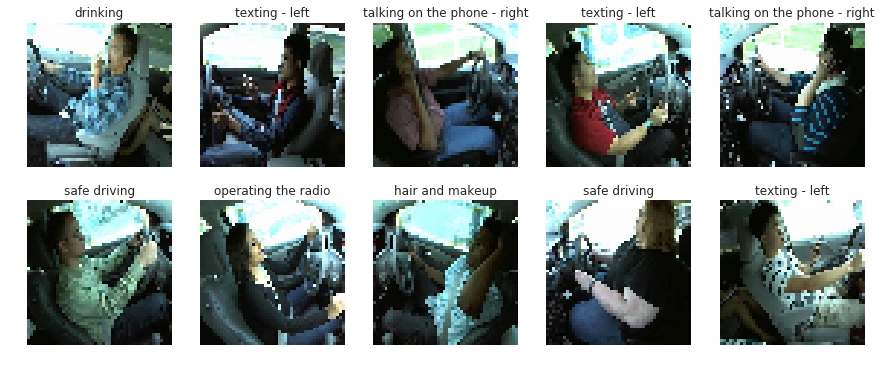

In [32]:
plot_classes(dset_loaders['train'], labels)

In [33]:
def plot_distribution(img):
    
    if img.shape[2] != 3:
        img = img.transpose((1, 2, 0))
        
    color_lst = ['red', 'green', 'blue']
    for i in range(0, img.shape[2]):
        c1=img[:,:,i].reshape(-1)
        plt.hist(c1, 50, facecolor=color_lst[i], label = color_lst[i])
    plt.legend()
    plt.grid(True)

In [34]:
def statistical_analysis_image(dset_loaders, labels, path2save = './figures/distribution.png'):

    
    fig = plt.figure(figsize=(15,6))
    inputs, cls = next(iter(dset_loaders))
    rand_idx = random.randrange(0, len(inputs))
    img = inputs.numpy()[rand_idx]
    img_denorm = denormalize(img)
    plt.subplot(2,2,2)
    plot_distribution(img_denorm)
    plt.title('Image RGB after denormalization')
    plt.subplot(2,2,4)
    plot_distribution(img)
    plt.title('Image RGB normalization')
    plt.subplot(1,2,1)
    img_denorm = np.clip(img_denorm, 0, 1.0)
    plt.imshow(img_denorm)
    plt.title('{}'.format(labels['c'+str(cls[rand_idx])]))
    plt.axis('off')
    fig.savefig(path2save)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


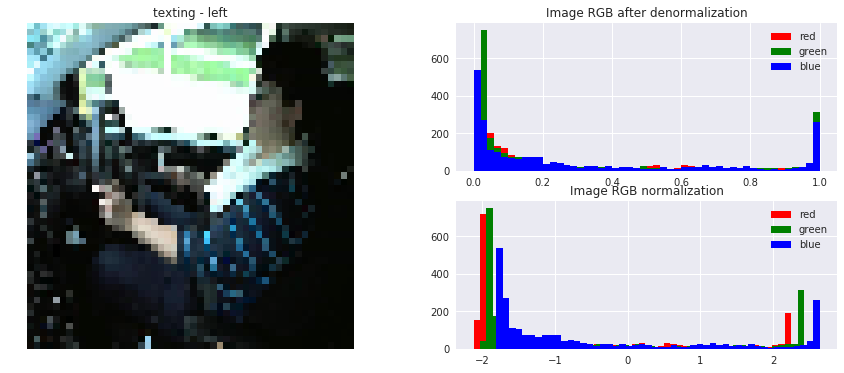

In [35]:
statistical_analysis_image(dset_loaders['train'], labels)

# Data Analysis

In [36]:
def code2label(dataset, labels): 
    class_str = []
    for item in dataset.y:
        class_str.append(labels['c'+str(item)])  
    return class_str           

In [37]:
class_str = code2label(dsets['train'], labels)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


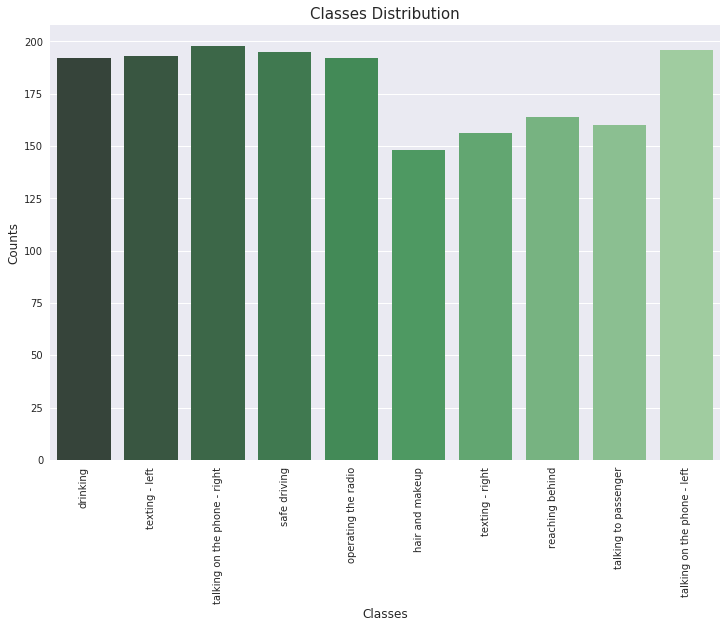

In [143]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Classes Distribution", fontsize=15)
plt.show()
path2save = './figures/distribution_classes.png'
fig.savefig(path2save)

In [39]:
nb_out = len(set(class_str))

In [97]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        del self.fc
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64, out_features=32)
        self.dens2 = torch.nn.Linear(in_features=32, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

In [98]:
model = MyResNet()
if use_gpu:
    model.cuda()
    !free -h
    !nvidia-smi
    model = torch.nn.DataParallel(MyResNet())

In [99]:
print(model)

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [165]:
def predict_convolutional(dset_loaders, model, get_labels = False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, (inputs, labels) in enumerate(dset_loaders):
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        if get_labels:
            labels_lst.append(labels)

        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'input': torch.cat(predictions, 0), 'ouput':torch.cat(labels_lst, 0) }

In [166]:
convOutput_train = predict_convolutional(dset_loaders['train'], model.mrnc, get_labels= True)
convOutput_valid = predict_convolutional(dset_loaders['valid'], model.mrnc, get_labels= True)

predict: 56/56 ok
predict: 13/13 ok


In [167]:
print(convOutput_train['input'].size(), convOutput_train['ouput'].size())
print(convOutput_valid['input'].size(), convOutput_valid['ouput'].size())

torch.Size([1794, 64]) torch.Size([1794])
torch.Size([448, 64]) torch.Size([448])


In [168]:
conv_dset ={
    'train': TensorDataset(convOutput_train['input'], convOutput_train['ouput']),
    'valid': TensorDataset(convOutput_valid['input'], convOutput_valid['ouput'])
} 

In [169]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, cpu_count)

In [105]:
optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [106]:
savebest = ptt.ModelCheckpoint('/home/r120084/project/models/distractdriver',reset=False, verbose=1)

params = {'model' : model.mrnd, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
        }

In [132]:
trainer = ptt.DeepNetTrainer(**params)

In [133]:
trainer.fit_loader(500, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 500 epochs
  1:   1.5s   T: 1.83316   V: 1.96955 best
  2:   1.5s   T: 1.84192   V: 1.96630 best
  3:   1.7s   T: 1.83868   V: 1.96480 best
  4:   1.4s   T: 1.83709   V: 1.96334 best
  5:   1.3s   T: 1.83470   V: 1.96258 best
  6:   1.2s   T: 1.83323   V: 1.96128 best
  7:   1.8s   T: 1.83096   V: 1.96002 best
  8:   1.1s   T: 1.82969   V: 1.95849 best
  9:   1.2s   T: 1.82734   V: 1.95731 best
 10:   1.3s   T: 1.82491   V: 1.95581 best
 11:   1.4s   T: 1.82379   V: 1.95530 best
 12:   1.6s   T: 1.82175   V: 1.95417 best
 13:   1.4s   T: 1.81981   V: 1.95329 best
 14:   1.4s   T: 1.81797   V: 1.95188 best
 15:   1.5s   T: 1.81574   V: 1.95088 best
 16:   1.3s   T: 1.81434   V: 1.95008 best
 17:   1.6s   T: 1.81272   V: 1.94921 best
 18:   1.3s   T: 1.81106   V: 1.94816 best
 19:   1.5s   T: 1.80910   V: 1.94706 best
 20:   1.2s   T: 1.80752   V: 1.94601 best
 21:   1.3s   T: 1.80605   V: 1.94572 best
 22:   1.4s   T: 1.80437   V: 1.94473 best
 23:   1.3s   T: 1.80261

393:   1.4s   T: 1.50752   V: 1.77824 best
394:   1.6s   T: 1.50696   V: 1.78062 
395:   1.4s   T: 1.50661   V: 1.77679 best
396:   1.5s   T: 1.50561   V: 1.77716 
397:   1.8s   T: 1.50548   V: 1.77807 
398:   1.4s   T: 1.50501   V: 1.77763 
399:   1.5s   T: 1.50488   V: 1.77745 
400:   2.0s   T: 1.50396   V: 1.77655 best
401:   1.5s   T: 1.50359   V: 1.77795 
402:   1.7s   T: 1.50327   V: 1.77794 
403:   1.4s   T: 1.50273   V: 1.77557 best
404:   1.4s   T: 1.50192   V: 1.77676 
405:   1.4s   T: 1.50164   V: 1.77596 
406:   1.6s   T: 1.50111   V: 1.77534 best
407:   1.6s   T: 1.50081   V: 1.77465 best
408:   1.2s   T: 1.50004   V: 1.77324 best
409:   1.6s   T: 1.49893   V: 1.77363 
410:   1.5s   T: 1.49853   V: 1.77357 
411:   1.6s   T: 1.49834   V: 1.77477 
412:   1.6s   T: 1.49756   V: 1.77394 
413:   1.4s   T: 1.49744   V: 1.77373 
414:   1.4s   T: 1.49740   V: 1.77341 
415:   1.3s   T: 1.49702   V: 1.77246 best
416:   1.5s   T: 1.49636   V: 1.77371 
417:   1.5s   T: 1.49574   V: 1.

In [134]:
if use_gpu:
    !free -h
    !nvidia-smi

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


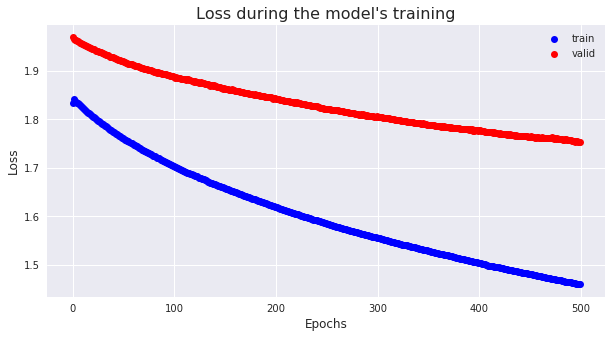

In [142]:
path2save = './figures/results_metrics.png'

fig = plt.figure(figsize=(10,5))
metrics_map = {'losses': 'Loss', 'acc': 'Acuracy'}

metrics_eval_nb = len(trainer.metrics['train'].keys())
count = 1
for metric in trainer.metrics['train'].keys():
    plt.subplot(1,metrics_eval_nb, count)
    plt.plot(trainer.metrics['train'][metric], 'ob', label = 'train')
    plt.plot(trainer.metrics['valid'][metric], 'or', label = 'valid')
    count += 1
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel(metrics_map[metric], fontsize = 12)
    plt.title(metrics_map[metric] + " during the model's training", fontsize = 16)
    plt.legend()
fig.savefig(path2save)

In [260]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 56/56 ok
evaluate: 13/13 ok


In [261]:
train_eval, valid_eval

({'losses': 1.5947763283250058}, {'losses': 1.7537271891321455})

In [276]:
def predict_images(dset):

    output_true = []
    output_pred_lst = []
    correct = 0
    for i, (inputs, outputs) in enumerate(dset):
        if use_gpu:
            inputs = inputs.cuda()
            outputs = outputs.cuda()
        output_pred = trainer.predict(inputs)      
        _, predicted = torch.max(output_pred, 0)
        predicted = predicted.numpy()
        correct += (predicted == outputs)
        output_pred_lst.append(predicted[0])
        output_true.append(outputs)
    output_pred_lst = np.array(output_pred_lst)
    output_true = np.array(output_true)

    result = {'true': output_true, 'pred': output_pred_lst}
    return result

In [277]:
result_train = predict_images(conv_dset['train'])
result_valid = predict_images(conv_dset['valid'])

In [283]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [284]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

Train:  812 / 1794
Valid:  190 / 448


In [301]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

In [328]:
def visualize_predictions(dsets, lst, path2save = []):

    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,4)):
        fig.add_subplot(1,4, i+1)
        (inputs, output) = dsets[lst[j]]
        img = denormalize(inputs.numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        #plt.title('{0} / {1}'.format(labels['c'+str(output)],  labels[('c'+str(result_train['pred'][lst[j]]))]))    
        plt.title('{0} / {1}'.format(('c'+str(output)),  ('c'+str(result_train['pred'][lst[j]]))))    
        plt.axis('off')
    if len(path2save) !=0:
        fig.savefig(path2save)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


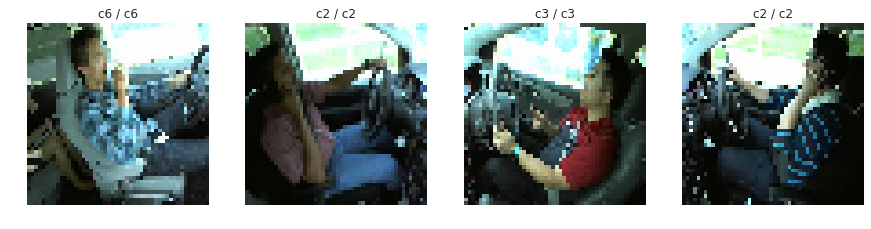

In [329]:
visualize_predictions(dsets['train'], lst_correct)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


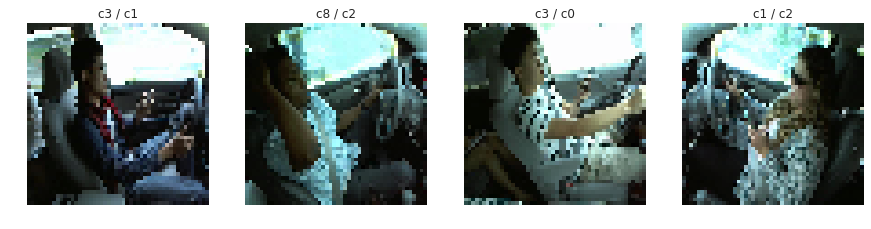

In [330]:
visualize_predictions(dsets['train'], lst_incorrect)